In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

In [2]:
# глобальные переменные

file_path_data = r'C:\Users\kakorin_is\Desktop\JupiterNotebook_files\Дела ЮФО на 28.02.xlsx'
file_path_activities = r'C:\Users\kakorin_is\Desktop\JupiterNotebook_files\активности нст на 15 февр.xlsx'

dollar_exchange_rate = 70
euro_exchange_rate = 70

                 # ГГ,  ММ, ДД
date_of_end = date(2023, 3, 31)

In [3]:
data = pd.read_excel(file_path_data, index_col=None)
activities = pd.read_excel(file_path_activities, index_col=None)

data.shape

(5555, 60)

In [4]:
data = data.loc[(data['Статус'] != 'Завершено') & (data['Статус'] != 'Отменено')]
data.shape

(852, 60)

In [5]:
data['Статус'].value_counts()

В работе             843
Приостановлено         5
Частично передано      4
Name: Статус, dtype: int64

In [6]:
data['Тип сокр'] = data['Тип']
data['Тип сокр'] = data['Тип сокр'].convert_dtypes()

data['Тип сокр'] = np.where((data['Тип сокр'] == 'Банкротство ФЛ РБ'), 'Банкротство РБ', data['Тип сокр'])
data['Тип сокр'] = np.where((data['Тип сокр'] == 'Банкротство ЮЛ МБ'), 'Банкротство МБ', data['Тип сокр'])    
data['Тип сокр'] = np.where((data['Тип сокр'] == 'Банкротство ФЛ МБ'), 'Банкротство МБ', data['Тип сокр'])    
data['Тип сокр'] = np.where((data['Тип сокр'] == 'Взыскание задолженности ПА РБ'), 'Взыскание РБ', data['Тип сокр'])
data['Тип сокр'] = np.where((data['Тип сокр'] == 'Взыскание задолженности ПА МБ'), 'Взыскание МБ', data['Тип сокр'])

# проверяем все ли корректно:
data.groupby(['Тип сокр','Тип']).agg({'Номер по SIEBEL': ['count']})

Номер по SIEBEL
                                                       count
Тип сокр       Тип                                          
Банкротство МБ Банкротство ФЛ МБ                           4
               Банкротство ЮЛ МБ                          11
Банкротство РБ Банкротство ФЛ РБ                         525
Взыскание МБ   Взыскание задолженности ПА МБ              32
Взыскание РБ   Взыскание задолженности ПА РБ             280

__Теперь по каждому делу нужно:__ 

- расставить признак СТ/НСТ, <br>
- посчитать кол-во дней на конец квартала,<br>
- расставить коэф., используя коэф. закрытых дел, <br>
- посчитать по каждому Типу дел суммы, сидящие в соотв. коэффициентном периоде (нормативном периоде) - по банкротам это Сумма заявл. треб, а по остальным ОД и %, а там, где 0 - сумма по ОД и %.

Ранее учтенные буду учитывать, т.к. в данном случае мы смотрим какие суммы зависли на суд. этапе.<br>
Обращение взыскания на залог после ИНН также буду считать, т.к. залог это покрытие неисполненного долга.

Сначала преобразую колонки дат и сумм, а потом двинемся по порядку.

In [7]:
# Функция преобразования даты
def fix_date(some_date):
    some_date = some_date.date()
    
    return some_date

# Специально делаю отдельный столбец к корректной формой даты, чтобы можно было потом сравнить
data['Дата создания'] = data['Дата создания дела'].apply(lambda x: fix_date(x))

# подтягиваю НСТ
activities = activities.loc[:, ['Судебное дело', 'Статус']]
activities.rename(columns={'Судебное дело' : 'Номер по SIEBEL', 'Статус': 'Статус активности нст'}, inplace=True)
activities['Статус активности нст'].replace("Запланировано", "Завершено", inplace=True)
activities = activities.loc[activities['Статус активности нст'] == 'Завершено']
data = pd.merge(data, activities,  on ='Номер по SIEBEL', how ='left')

# исходя из наличия корректных активностей, заполняем поле СТ/НСТ
data['СТ/НСТ'] = np.where(data['Статус активности нст'] == 'Завершено' , 'НСТ', 'СТ')
data['СТ/НСТ'].value_counts()

СТ     799
НСТ     74
Name: СТ/НСТ, dtype: int64

In [8]:
# корректирую суммы заявл.требований
def replace_and_fix_values(x):
    if type(x) == str: # обхожу ошибку типа данных, когда встречается ноль
        
        # обрабатываем Руб.
        x_fixed = x.replace("Руб.", "")
        
        # приводим в корректный вид для преобразования в числовой формат
        x_fixed = x_fixed.replace(" ", "")    # пробелы между цифрами нужно также убрать
        x_fixed = x_fixed.replace(",", ".")   # в питоне у флоата точка вместо запятой
        
        # сразу убираю символ доллара и перевожу доллары в рубли
        if '$' in x_fixed:
            x_fixed = x_fixed.replace("$", "")
            x_fixed = str(float(x_fixed) * dollar_exchange_rate)  # 70 берем за текущий курс доллара
        
        # аналогичное для евро
        if '€' in x_fixed:
            x_fixed = x_fixed.replace("€", "")
            x_fixed = str(float(x_fixed) * euro_exchange_rate)  # на начало 2023 г. курсы валют примерно одинаковые
        
        return x_fixed
    return x


data['Сумма заявленных требований'] = data['Сумма заявленных требований'].apply(lambda x: replace_and_fix_values(x))

# переписываю тип данных
data = data.astype({'Сумма заявленных требований': np.float64})

In [9]:
# перевожу валюту в колонках ОД и %
data.loc[data['Валюта заявленных требований']=='USD', 'Общая сумма ПЗ по ОД'] *= dollar_exchange_rate
data.loc[data['Валюта заявленных требований']=='USD', 'Сумма просроченных процентов'] *= dollar_exchange_rate

data.loc[data['Валюта заявленных требований']=='EUR', 'Общая сумма ПЗ по ОД'] *= euro_exchange_rate
data.loc[data['Валюта заявленных требований']=='EUR', 'Сумма просроченных процентов'] *= euro_exchange_rate

In [10]:
data.loc[:,['Общая сумма ПЗ по ОД','Сумма просроченных процентов']]

,Общая сумма ПЗ по ОД,Сумма просроченных процентов
0,59281.32,7139.14
1,175467.50,46695.65
2,315937.21,47946.16
3,304797.90,17640.59
4,96591.70,12935.15
...,...,...
868,260353.52,20571.22
869,NaN,NaN
870,NaN,NaN
871,NaN,NaN


In [11]:
#видим что наны присутствуют только в банкротных делах, потому по ним будем тянуть сумму заявл. требований
data[pd.isnull(data['Общая сумма ПЗ по ОД'])]['Тип сокр'].value_counts()

Банкротство РБ    525
Банкротство МБ     16
Name: Тип сокр, dtype: int64

In [12]:
# заменю наны на нули
data['Общая сумма ПЗ по ОД'].fillna(0, inplace=True)
data['Сумма просроченных процентов'].fillna(0, inplace=True) 

In [13]:
data.loc[:,['Общая сумма ПЗ по ОД','Сумма просроченных процентов']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Общая сумма ПЗ по ОД          873 non-null    float64
 1   Сумма просроченных процентов  873 non-null    float64
dtypes: float64(2)
memory usage: 20.5 KB


Обе колонки яв-ся числовыми данными, с ними можно проводить мат. операции.

Считаю кол-во дней:

In [14]:
data['Дата конца'] = date_of_end #datetime(2023, 3, 31, 23, 59, 0, 1).date()


def count_num_days(row):
    if (row['Дата создания'] >= datetime(2022, 12, 15, 0, 0, 0, 1).date()) and \
    (row['Дата создания'] <= datetime(2023, 1, 19, 0, 0, 0, 1).date()):
        date_x = row['Дата конца'] - row['Дата создания'] - timedelta(days=35)
        return date_x.days

    # для всех остальных случаев
    date_x = row['Дата конца'] - row['Дата создания']
    return date_x.days

data['Кол-во дней'] = data.apply(count_num_days, axis=1)

In [15]:
cols_list = ['Номер по SIEBEL',  'Статус', 'Сумма заявленных требований','Дата создания', 'Дата конца',\
             'Дата закрытия','Кол-во дней', 'СТ/НСТ', 'Статус активности нст','Тип сокр',\
             'Общая сумма ПЗ по ОД', 'Сумма просроченных процентов']

# пока выключаю
# add_to_cols_list = ['Ответственный','Комментарии']
# cols_list += add_to_cols_list

data_cuted = data.loc[:, cols_list]
data_cuted.head(3)

,Номер по SIEBEL,Статус,Сумма заявленных требований,Дата создания,Дата конца,Дата закрытия,Кол-во дней,СТ/НСТ,Статус активности нст,Тип сокр,Общая сумма ПЗ по ОД,Сумма просроченных процентов
0,1-2922685695,В работе,120106.50,2022-10-11,2023-03-31,NaT,171,СТ,NaN,Взыскание РБ,59281.32,7139.14
1,1-2566500297,В работе,222163.15,2022-06-06,2023-03-31,NaT,298,СТ,NaN,Взыскание РБ,175467.50,46695.65
2,1-2566858573,В работе,384892.89,2022-06-06,2023-03-31,NaT,298,СТ,NaN,Взыскание РБ,315937.21,47946.16


In [16]:
def get_coef(row):
    if row['СТ/НСТ'] == 'СТ':                     
        if row['Тип сокр'] == 'Банкротство РБ':
            if row['Кол-во дней'] <= 60:
                return 'предцелевой'
            if (row['Кол-во дней'] > 60) and (row['Кол-во дней'] <= 100):
                return 'целевой'
            if (row['Кол-во дней'] > 100) and (row['Кол-во дней'] <= 220):
                return 'допустимый'
            if row['Кол-во дней'] > 220:
                return 'штрафной'

        if row['Тип сокр'] == 'Банкротство МБ':
            if row['Кол-во дней'] <= 80:
                return 'предцелевой'
            if (row['Кол-во дней'] > 80) and (row['Кол-во дней'] <= 170):
                return 'целевой'
            if (row['Кол-во дней'] > 170) and (row['Кол-во дней'] <= 290):
                return 'допустимый'
            if row['Кол-во дней'] > 290:
                return 'штрафной'

        if row['Тип сокр'] == 'Взыскание МБ':
            if row['Кол-во дней'] <= 160:
                return 'предцелевой'
            if (row['Кол-во дней'] > 160) and (row['Кол-во дней'] <= 180):
                return 'целевой'
            if (row['Кол-во дней'] > 180) and (row['Кол-во дней'] <= 300):
                return 'допустимый'
            if row['Кол-во дней'] > 300:
                return 'штрафной'

        if row['Тип сокр'] == 'Взыскание РБ':
            if row['Кол-во дней'] <= 160:
                return 'предцелевой'
            if (row['Кол-во дней'] > 160) and (row['Кол-во дней'] <= 170):
                return 'целевой'
            if (row['Кол-во дней'] > 170) and (row['Кол-во дней'] <= 290):
                return 'допустимый'
            if row['Кол-во дней'] > 290:
                return 'штрафной'

    # Блок НСТ
    if row['Тип сокр'] == 'Банкротство РБ':
            if row['Кол-во дней'] <= 60:
                return 'предцелевой'
            if (row['Кол-во дней'] > 60) and (row['Кол-во дней'] <= 250):
                return 'целевой'
            if (row['Кол-во дней'] > 250) and (row['Кол-во дней'] <= 370):
                return 'допустимый'
            if row['Кол-во дней'] > 370:
                return 'штрафной'

    if row['Тип сокр'] == 'Банкротство МБ':
        if row['Кол-во дней'] <= 80:
            return 'предцелевой'
        if (row['Кол-во дней'] > 80) and (row['Кол-во дней'] <= 390):
            return 'целевой'
        if (row['Кол-во дней'] > 390) and (row['Кол-во дней'] <= 510):
            return 'допустимый'
        if row['Кол-во дней'] > 510:
            return 'штрафной'

    if row['Тип сокр'] == 'Взыскание МБ':
        if row['Кол-во дней'] <= 180:
            return 'предцелевой'
        if (row['Кол-во дней'] > 180) and (row['Кол-во дней'] <= 300):
            return 'целевой'
        if (row['Кол-во дней'] > 300) and (row['Кол-во дней'] <= 420):
            return 'допустимый'
        if row['Кол-во дней'] > 420:
            return 'штрафной'

    if row['Тип сокр'] == 'Взыскание РБ':
        if row['Кол-во дней'] <= 160:
            return 'предцелевой'
        if (row['Кол-во дней'] > 160) and (row['Кол-во дней'] <= 270):
            return 'целевой'
        if (row['Кол-во дней'] > 270) and (row['Кол-во дней'] <= 390):
            return 'допустимый'
        if row['Кол-во дней'] > 390:
            return 'штрафной'

                
   
            
data_cuted['Коэф'] = data_cuted.apply(get_coef, axis=1)

In [17]:
data_cuted['Коэф'].value_counts()

предцелевой    494
допустимый     176
целевой        161
штрафной        42
Name: Коэф, dtype: int64

In [18]:
def compute_summ(row):
    # по банкротам сразу заявл. требования будем тянуть
    if (row['Тип сокр'] == 'Банкротство РБ') or (row['Тип сокр'] == 'Банкротство МБ'):
        return row['Сумма заявленных требований']

    # по не банкротам суммируем ОД и %
    result = row['Общая сумма ПЗ по ОД'] + row['Сумма просроченных процентов']
    if result == 0:
        result = row['Сумма заявленных требований']

    return result

data_cuted['Сумма задолженности скорр.'] = data_cuted.apply(compute_summ, axis=1)

In [19]:
table_0 = pd.pivot_table(data_cuted, values='Сумма задолженности скорр.', index=['Коэф'], columns=['Тип сокр'], aggfunc=np.sum)
table_0

Тип сокр,Банкротство МБ,Банкротство РБ,Взыскание МБ,Взыскание РБ
Коэф,,,,
допустимый,1.718594e+08,8.464713e+07,2.293814e+07,56850182.15
предцелевой,9.086271e+07,2.023712e+08,1.927352e+08,82328265.85
целевой,4.259282e+07,9.745258e+07,5.734272e+07,34428530.50
штрафной,1.890182e+06,5.472865e+06,9.360876e+07,9312747.66


В условиях демонстрации материала, выключаю реальные суммы.

__ВЫКЛЮЧИТЬ БЛОК ПРИ РЕАЛЬНОЙ РАБОТЕ!__


####################################################

In [21]:
#еще раз смотрим кол-во строк
data_cuted.shape

(873, 14)

In [25]:
# генерирую рандомные значения сумм в диапазоне от 100 тыс. до 70 млн
import random

to_replace_summ = [random.uniform(100000.00, 70000000.99) for i in range(data_cuted.shape[0])]
len(to_replace_summ)

873

In [26]:
# переписываю столбец
data_cuted['Сумма задолженности скорр.'] = to_replace_summ

data_cuted['Сумма задолженности скорр.'][:5]

0    5.147539e+07
1    8.392322e+06
2    4.291503e+07
3    3.603558e+07
4    4.614829e+07
Name: Сумма задолженности скорр., dtype: float64

In [27]:
# перезапись прошла успешно
to_replace_summ[:5]

[51475387.07098438,
 8392322.328601189,
 42915028.293123014,
 36035579.506932944,
 46148294.52172305]

конец блока для выключения.<br>
##############################################################

In [28]:
# делаем заново сводную таблицу
table = pd.pivot_table(data_cuted, values='Сумма задолженности скорр.', index=['Коэф'], columns=['Тип сокр'], aggfunc=np.sum)
table

Тип сокр,Банкротство МБ,Банкротство РБ,Взыскание МБ,Взыскание РБ
Коэф,,,,
допустимый,1.209459e+08,3.979363e+09,1.782464e+08,2.276017e+09
предцелевой,1.993846e+08,9.983403e+09,4.805262e+08,5.830686e+09
целевой,1.678284e+08,4.144692e+09,2.789525e+08,1.272445e+09
штрафной,3.976788e+07,1.911837e+08,4.548948e+08,7.317816e+08


__Здесь практикуюсь выводить пироговую таблицу:__

Финальная таблица будет ниже

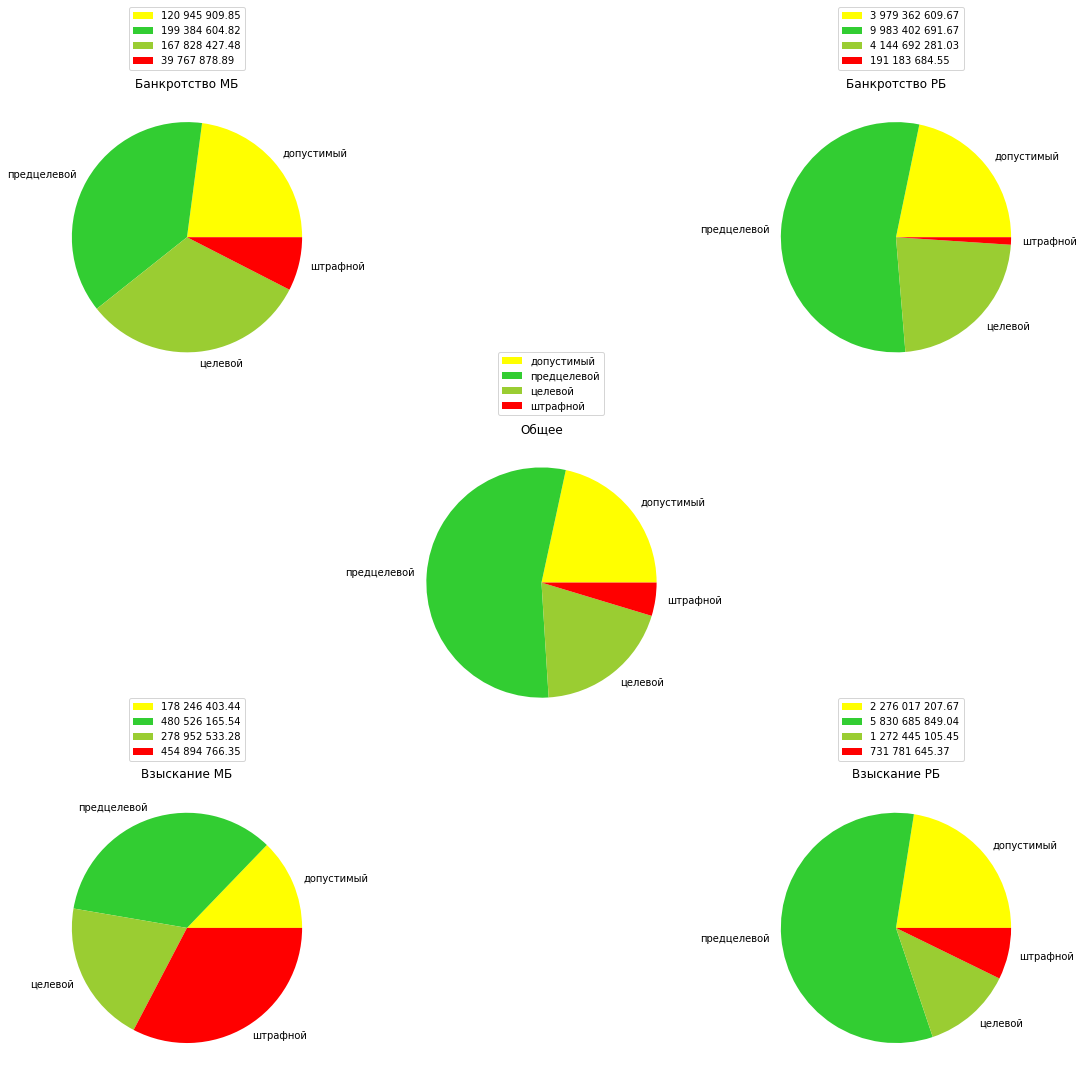

In [35]:
import decimal
def make_money_view(some_float):
    n = decimal.Decimal(f'{some_float: .2f}')
    return '{0:,}'.format(n).replace(',', ' ')

def make_plot(data):
    type_bussines =  sorted(list(data['Тип сокр'].unique()))
    
    plt.figure(figsize=(30, 30))
    
    axes_el = 1
    for i  in type_bussines:
        type_bussines_table = data.loc[data['Тип сокр'] == i]
        sum_yellow = type_bussines_table.loc[type_bussines_table['Коэф'] == 'допустимый']['Сумма задолженности скорр.'].values.sum()
        sum_yellow = make_money_view(sum_yellow)

        sum_limegreen = type_bussines_table.loc[type_bussines_table['Коэф'] == 'предцелевой']['Сумма задолженности скорр.'].values.sum()
        sum_limegreen = make_money_view(sum_limegreen)

        sum_yellowgreen = type_bussines_table.loc[type_bussines_table['Коэф'] == 'целевой']['Сумма задолженности скорр.'].values.sum()
        sum_yellowgreen = make_money_view(sum_yellowgreen)

        sum_red = type_bussines_table.loc[type_bussines_table['Коэф'] == 'штрафной']['Сумма задолженности скорр.'].values.sum()
        sum_red = make_money_view(sum_red)
        
        if axes_el == 1:
            plt.subplot(3, 3, axes_el)
        if axes_el == 2:
            plt.subplot(3, 3, axes_el+1)
        if axes_el == 3:
            plt.subplot(3, 3, axes_el+4)
        if axes_el == 4:
            plt.subplot(3, 3, axes_el+5)
            
        type_bussines_table.groupby(['Коэф'])['Сумма задолженности скорр.'].sum().plot(
            kind='pie',
            figsize=(15,15),
            colors=[ 'yellow', 'limegreen','yellowgreen','red'], 
        )
        plt.title(i)
        plt.ylabel('')
        plt.legend((sum_yellow, sum_limegreen,sum_yellowgreen, sum_red ),  bbox_to_anchor=(0.3 , 1.3), loc='upper left', borderaxespad= 0)
        axes_el +=1
        
    plt.subplot(3, 3, 5)
    plt.title('Общее')
    data.groupby(['Коэф'])['Сумма задолженности скорр.'].sum().plot(
        kind='pie',
        figsize=(18,18),
        colors=[ 'yellow', 'limegreen','yellowgreen','red'], 

    )
    plt.ylabel('')
    plt.legend(bbox_to_anchor=( 0.35 , 1.3 ), loc='upper left', borderaxespad= 0)
    
make_plot(data_cuted)#, make_plot("Банкротство MБ"), make_plot("Взыскание РБ"),make_plot("Взыскание МБ")

На будущее  - добавить в центральный пирог суммы.


Далее тестовая часть в поиске оптимальной формы (нет нормирования), сохраняю себе на память.

In [36]:
table1 = data_cuted.groupby(['Тип сокр', 'Коэф'])['Сумма задолженности скорр.'].sum()
#data1 = pd.DataFrame(table1)
table1

Тип сокр        Коэф       
Банкротство МБ  допустимый     1.209459e+08
                предцелевой    1.993846e+08
                целевой        1.678284e+08
                штрафной       3.976788e+07
Банкротство РБ  допустимый     3.979363e+09
                предцелевой    9.983403e+09
                целевой        4.144692e+09
                штрафной       1.911837e+08
Взыскание МБ    допустимый     1.782464e+08
                предцелевой    4.805262e+08
                целевой        2.789525e+08
                штрафной       4.548948e+08
Взыскание РБ    допустимый     2.276017e+09
                предцелевой    5.830686e+09
                целевой        1.272445e+09
                штрафной       7.317816e+08
Name: Сумма задолженности скорр., dtype: float64

In [37]:
table1.values, len(table1.values)

(array([1.20945910e+08, 1.99384605e+08, 1.67828427e+08, 3.97678789e+07,
        3.97936261e+09, 9.98340269e+09, 4.14469228e+09, 1.91183685e+08,
        1.78246403e+08, 4.80526166e+08, 2.78952533e+08, 4.54894766e+08,
        2.27601721e+09, 5.83068585e+09, 1.27244511e+09, 7.31781645e+08]),
 16)

In [38]:
# Взять из списка элементы со 4-го по 16-ой с шагом 4
table1.values[3:16:4]

array([3.97678789e+07, 1.91183685e+08, 4.54894766e+08, 7.31781645e+08])

##### Из table1 буду делать 4 списка по каждому коэффициентному периоду чтобы потом все это подать в .plot.barh

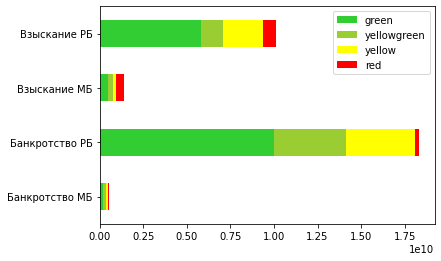

In [39]:
#data_cuted.groupby(['Тип сокр'])['Сумма задолженности скорр.'].sum().plot.barh(stacked=True)
index = ['Банкротство МБ', 'Банкротство РБ', 'Взыскание МБ',
         'Взыскание РБ']


yellow = table1.values[0:16:4]
red = table1.values[3:16:4]
green = table1.values[1:16:4]
yellowgreen = table1.values[2:16:4]


df = pd.DataFrame({'green': green,
                   'yellowgreen': yellowgreen,
                   'yellow': yellow,
                   'red': red}, index=index)

ax = df.plot.barh(stacked=True, color={"green": 'limegreen', "yellowgreen": 'yellowgreen', "yellow": 'yellow',  "red": 'red'})



Получилось не совсем то, что хотел.

Идем дальше. Сначала переименую названия коэффициентных периодов, т.к. хочу чтобы нормативные периоды располагались в определенной последовательность - салатовый д.б. перед ярко зеленым.

In [40]:
data_cuted['Коэф'] = np.where((data_cuted['Коэф'] == 'предцелевой'), '1.предцелевой', data_cuted['Коэф'])
data_cuted['Коэф'] = np.where((data_cuted['Коэф'] == 'целевой'), '2.целевой', data_cuted['Коэф'])
data_cuted['Коэф'] = np.where((data_cuted['Коэф'] == 'допустимый'), '3.допустимый', data_cuted['Коэф'])
data_cuted['Коэф'] = np.where((data_cuted['Коэф'] == 'штрафной'), '4.штрафной', data_cuted['Коэф'])

In [41]:
table1 = data_cuted.groupby(['Тип сокр', 'Коэф'])['Сумма задолженности скорр.'].sum()
table1

Тип сокр        Коэф         
Банкротство МБ  1.предцелевой    1.993846e+08
                2.целевой        1.678284e+08
                3.допустимый     1.209459e+08
                4.штрафной       3.976788e+07
Банкротство РБ  1.предцелевой    9.983403e+09
                2.целевой        4.144692e+09
                3.допустимый     3.979363e+09
                4.штрафной       1.911837e+08
Взыскание МБ    1.предцелевой    4.805262e+08
                2.целевой        2.789525e+08
                3.допустимый     1.782464e+08
                4.штрафной       4.548948e+08
Взыскание РБ    1.предцелевой    5.830686e+09
                2.целевой        1.272445e+09
                3.допустимый     2.276017e+09
                4.штрафной       7.317816e+08
Name: Сумма задолженности скорр., dtype: float64

__Финальная часть написания графика.__

Поскольку хочу чтобы на график выводились суммы по каждому периоду и кол-во дел, то пишу ф-цию compute_dict:

In [43]:
import decimal
def make_money_view(some_float):
    n = decimal.Decimal(f'{some_float: .2f}')
    return '{0:,}'.format(n).replace(',', ' ')


def compute_dict(data):
    result = {}
    type_bussines =  sorted(list(data['Тип сокр'].unique()))
    for i  in type_bussines:
        hidden_dict = {}
        
        # беру тип, например Банкротство РБ
        type_bussines_table = data.loc[data['Тип сокр'] == i]
        
        sum_yellow = type_bussines_table.loc[type_bussines_table['Коэф'] == '3.допустимый']['Сумма задолженности скорр.'].values.sum()
        yellow_len = type_bussines_table.loc[type_bussines_table['Коэф'] == '3.допустимый']['Сумма задолженности скорр.'].shape[0]
        hidden_dict['допустимый'] = [make_money_view(sum_yellow), yellow_len]


        sum_limegreen = type_bussines_table.loc[type_bussines_table['Коэф'] == '1.предцелевой']['Сумма задолженности скорр.'].values.sum()
        limegreen_len = type_bussines_table.loc[type_bussines_table['Коэф'] == '1.предцелевой']['Сумма задолженности скорр.'].shape[0]
        hidden_dict['предцелевой'] = [make_money_view(sum_limegreen), limegreen_len]
        
        sum_yellowgreen = type_bussines_table.loc[type_bussines_table['Коэф'] == '2.целевой']['Сумма задолженности скорр.'].values.sum()
        yellowgreen_len = type_bussines_table.loc[type_bussines_table['Коэф'] == '2.целевой']['Сумма задолженности скорр.'].shape[0]
        hidden_dict['целевой'] = [make_money_view(sum_yellowgreen), yellowgreen_len]
        
        sum_red = type_bussines_table.loc[type_bussines_table['Коэф'] == '4.штрафной']['Сумма задолженности скорр.'].values.sum()
        red_len = type_bussines_table.loc[type_bussines_table['Коэф'] == '4.штрафной']['Сумма задолженности скорр.'].shape[0]
        hidden_dict['штрафной'] = [make_money_view(sum_red),red_len]
        
        result[i] = hidden_dict
    return result

In [44]:
result = compute_dict(data_cuted)
result

{'Банкротство МБ': {'допустимый': ['120 945 909.85', 3],
  'предцелевой': ['199 384 604.82', 7],
  'целевой': ['167 828 427.48', 5],
  'штрафной': ['39 767 878.89', 1]},
 'Банкротство РБ': {'допустимый': ['3 979 362 609.67', 107],
  'предцелевой': ['9 983 402 691.67', 299],
  'целевой': ['4 144 692 281.03', 114],
  'штрафной': ['191 183 684.55', 5]},
 'Взыскание МБ': {'допустимый': ['178 246 403.44', 5],
  'предцелевой': ['480 526 165.54', 15],
  'целевой': ['278 952 533.28', 7],
  'штрафной': ['454 894 766.35', 12]},
 'Взыскание РБ': {'допустимый': ['2 276 017 207.67', 61],
  'предцелевой': ['5 830 685 849.04', 173],
  'целевой': ['1 272 445 105.45', 35],
  'штрафной': ['731 781 645.37', 24]}}

__Вывожу график.__

Примечание - в последующих выводах придется вручную по горизонтали располагать цифры - тут подогнал.

Text(95, 0.0, '1')

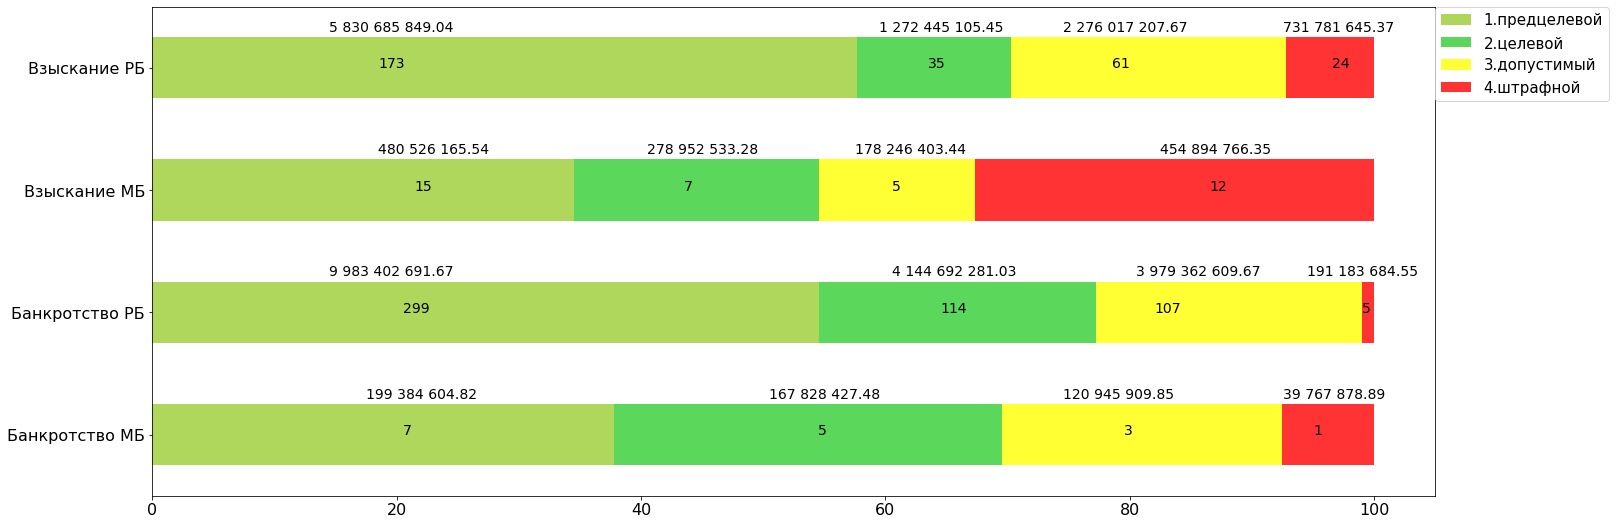

In [70]:
%matplotlib inline



# Set general font size
plt.rcParams['font.size'] = '16'

# # Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(16)

table1.div(table1.sum(level='Тип сокр')).mul(100).unstack('Коэф').plot.barh(stacked=True,\
    color={"2.целевой": 'limegreen', "1.предцелевой": 'yellowgreen', "3.допустимый": 'yellow',  "4.штрафной": 'red'},\
    figsize=(23, 9), width = 0.5, alpha=0.8)
                                                                           

plt.ylabel('', fontsize=17)
plt.legend(bbox_to_anchor=( 1 , 1 ), loc='upper left', borderaxespad= 0, fontsize=15)      

# отображение по салатовым [0] -сумма, [1] - кол-во дел
plt.text(14.5, 3.3, result['Взыскание РБ']['предцелевой'][0], fontsize=14)
plt.text(18.5, 2.3, result['Взыскание МБ']['предцелевой'][0], fontsize=14)
plt.text(14.5, 1.3, result['Банкротство РБ']['предцелевой'][0], fontsize=14)
plt.text(17.5, 0.3, result['Банкротство МБ']['предцелевой'][0], fontsize=14)
#------------
plt.text(18.5, 3.0, result['Взыскание РБ']['предцелевой'][1], fontsize=14)
plt.text(21.5, 2.0, result['Взыскание МБ']['предцелевой'][1], fontsize=14)
plt.text(20.5, 1.0, result['Банкротство РБ']['предцелевой'][1], fontsize=14)
plt.text(20.5, 0.0, result['Банкротство МБ']['предцелевой'][1], fontsize=14)

# отображение по ярко зеленым
plt.text(59.5, 3.3, result['Взыскание РБ']['целевой'][0], fontsize=14)
plt.text(40.5, 2.3, result['Взыскание МБ']['целевой'][0], fontsize=14)
plt.text(60.5, 1.3, result['Банкротство РБ']['целевой'][0], fontsize=14)
plt.text(50.5, 0.3, result['Банкротство МБ']['целевой'][0], fontsize=14)
#------------
plt.text(63.5, 3.0, result['Взыскание РБ']['целевой'][1], fontsize=14)
plt.text(43.5, 2.0, result['Взыскание МБ']['целевой'][1], fontsize=14)
plt.text(64.5, 1.0, result['Банкротство РБ']['целевой'][1], fontsize=14)
plt.text(54.5, 0.0, result['Банкротство МБ']['целевой'][1], fontsize=14)

# отображение по желтым
plt.text(74.5, 3.3, result['Взыскание РБ']['допустимый'][0], fontsize=14)
plt.text(57.5, 2.3, result['Взыскание МБ']['допустимый'][0], fontsize=14)
plt.text(80.5, 1.3, result['Банкротство РБ']['допустимый'][0], fontsize=14)
plt.text(74.5, 0.3, result['Банкротство МБ']['допустимый'][0], fontsize=14)
#------------
plt.text(78.5, 3.0, result['Взыскание РБ']['допустимый'][1], fontsize=14)
plt.text(60.5, 2.0, result['Взыскание МБ']['допустимый'][1], fontsize=14)
plt.text(82, 1.0, result['Банкротство РБ']['допустимый'][1], fontsize=14)
plt.text(79.5, 0.0, result['Банкротство МБ']['допустимый'][1], fontsize=14)

# отображение по красным
plt.text(92.5, 3.3, result['Взыскание РБ']['штрафной'][0], fontsize=14)
plt.text(82.5, 2.3, result['Взыскание МБ']['штрафной'][0], fontsize=14)
plt.text(94.5, 1.3, result['Банкротство РБ']['штрафной'][0], fontsize=14)
plt.text(92.5, 0.3, result['Банкротство МБ']['штрафной'][0], fontsize=14)
#------------
plt.text(96.5, 3.0, result['Взыскание РБ']['штрафной'][1], fontsize=14)
plt.text(86.5, 2.0, result['Взыскание МБ']['штрафной'][1], fontsize=14)
plt.text(99, 1.0, result['Банкротство РБ']['штрафной'][1], fontsize=14)
plt.text(95, 0.0, result['Банкротство МБ']['штрафной'][1], fontsize=14)

#fig.tight_layout() #  если несколько графиков в осях (тут такого нет),должен нормальные расстояния выбирать


# сохраняю график в картинку чтобы использовать в презентациях
plt.savefig('saved_figure.png')

Полезные ссылки: <br>
https://matplotlib.org/stable/tutorials/colors/colormaps.html <br>
https://www.codecamp.ru/blog/matplotlib-stacked-bar-chart/

In [ ]:
# Черновик

(df['count'].div(df.['count'].sum(level='player'))
            .mul(100)
            .unstack('action')
            .plot.barh(stacked=True)
)

этот попробовать потом
(df.groupby('players')['action']
   .value_counts(normalize=True)
   .unstack('action')
   .plot.barh(stacked=True)
)  